## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import plot_precision_recall_curve
import keras
import tensorflow_addons as tfa
import keras.backend as K
from tqdm import tqdm
plt.style.use("seaborn")
import torch
from torch import nn, optim
import torch.nn.functional as F

In [2]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)

# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [3]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Normalize data

In [4]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

## Compare hists between classes

In [5]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
#records0.hist(figsize=(20,20));

In [6]:
# print("Differences between fraud and non-fraud:")
# for i in records0.keys():
#     print("Differences in",i)
#     print("Median:", records0[i].median()-records1[i].median())
#     print("Mean:", records0[i].mean()-records1[i].mean())
#     print("Std:", records0[i].std()-records1[i].std())
    
#     print()

In [7]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'] #Based on largest difference in median.
top10_perm = ['V14','V12','V17','V10','V4','V16','V7','V2','V11','Amount']
X_median = normalized_records[top10].to_numpy()
y = targets.to_numpy()

X_perm = normalized_records[top10_perm].to_numpy()
X_all = normalized_records.to_numpy()

### Performance Metrics
The function below calculates a series of performance metrics.
1. Accuracy - This is the default metric and is not suited for this problem.
2. False negatives, False positives, True positives - Gives insight in how it classifies.
3. F1 score - Is considered suited for imbalanced datasets.
4. AUPRC - Area Under Precision-Recall Curve is the suggested metric from Kaggle.
5. AUC ROC - Area Under Curve Receiving Operating Characteristic is widely used for this specific task, but not good for imbalanced datasets
6. Average Precision - Should be a good overall measure for this task. 
7. Mean score for metrics - The mean for 3, 4, 5, 6

#True negatives are not printed due to it being the default classification.
def evaluate_model(model, name="", verbose=False, dataset=(X_all_smote, X_all_test, y_all_smote, y_all_test)):
    _, X_test, _, y_test = dataset
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, preds_proba)
    fpr, tpr, _ = roc_curve(y_test, preds_proba)
    f1 = f1_score(preds, y_test)
    aucroc = auc(fpr, tpr)
    auprc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, preds_proba)
    mean_score = np.mean([f1, auprc, aucroc, avg_precision])
    
    if verbose:
        cm = confusion_matrix(preds, y_test)
        tn, fp, fn, tp = cm.ravel()
        
        print("{} performance metrics:\n-=-=-=-=-=-".format(name))
        print("Raw accuracy (bad metric):", accuracy_score(preds, y_test))
        print("False negatives:", fn)
        print("False positives:", fp)
        print("True positives:", tp)
        print("F1 score:", f1)

        print("AUPRC:", auprc)
        print("AUC ROC:", aucroc)
        print("Average Precision Score:", avg_precision)
        print("Mean Score for Metrics:", mean_score)
        print()
    
    return [f1, auprc, aucroc, avg_precision, mean_score]

def print_scores(scores, name=""):
    print("{} performance metrics:\n-=-=-=-=-=-".format(name))
    print("F1 score:", scores[0])
    print("AUPRC:", scores[1])
    print("AUC ROC:", scores[2])
    print("Average Precision Score:", scores[3])
    print("Mean Score for Metrics:", scores[4])
    print()

def AUC_PR(preds_proba, y_test):
    precision, recall, _ = precision_recall_curve(y_test, preds_proba)
    auprc = auc(recall, precision)
    return auprc

## Evaluation
Using Stratified K-fold and the metrics above

In [9]:
oversample = imblearn.over_sampling.SMOTE()

#All dataset
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y, random_state=42)
X_all_smote, y_all_smote = oversample.fit_resample(X_all_train, y_all_train)

#Top 10 median dataset
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median, y, random_state=42)
X_median_smote, y_median_smote = oversample.fit_resample(X_median_train, y_median_train)

#Top 10 perm dataset
X_perm_train, X_perm_test, y_perm_train, y_perm_test = train_test_split(X_perm, y, random_state=42)
X_perm_smote, y_perm_smote = oversample.fit_resample(X_perm_train, y_median_train)

skf = StratifiedKFold(n_splits=5)
lrg = LogisticRegression(n_jobs=4, random_state=42)
knn = KNeighborsClassifier(n_jobs=4)
rfc = RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=42)
nbc = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=[1000,200], random_state=42) #1000 500
dum = DummyClassifier(random_state=42)


def cross_val_train_model(model, name="", dataset=(X_all_smote, X_all_test, y_all_smote, y_all_test)):
    X_train, X_test, y_train, y_test = dataset 
    
    accuracies = []
    for train_index, valid_index in tqdm(skf.split(X_train,y_train)):
        X_strat_train, X_valid = X_train[train_index], X_train[valid_index]
        y_strat_train, y_valid = y_train[train_index], y_train[valid_index]

        model.fit(X_strat_train, y_strat_train)
        accuracies.append(evaluate_model(model, dataset=dataset))

    print_scores(np.mean(accuracies, axis=0), name=name)

def model_prediction(model, dataset=(X_all_smote, X_all_test, y_all_smote, y_all_test)):
    X_train, X_test, y_train, y_test = dataset
    model.fit(X_train, y_train)
    return model.predict_proba(X_test)

In [110]:
#cross_val_train_model(dum, name="Baseline", dataset=(X_median_smote, X_median_test, y_median_smote, y_median_test))
# cross_val_train_model(lrg, name="Logistic Regression")
# cross_val_train_model(knn, name="K-Nearest neighbours")
# cross_val_train_model(rfc, name="Random Forest")
# cross_val_train_model(nb, name="Naive Bayes")
# cross_val_train_model(mlp, name="Multilayer Perceptron")

def train_on_all_sets(model, name=""):
    #Function does 5-fold cross validation and returns predictions on test set. 
    datasets = {
        'all' : (X_all_smote, X_all_test, y_all_smote, y_all_test),
        'median' : (X_median_smote, X_median_test, y_median_smote, y_median_test),
        'perm' : (X_perm_smote, X_perm_test, y_perm_smote, y_perm_test)
    }
    preds = {
        'all' : None,
        'median' : None,
        'perm' : None
    }
    for dataset in datasets:
        cross_val_train_model(model, name="{}_{}".format(name, dataset), dataset=datasets[dataset])
        preds[dataset] = model_prediction(model, dataset=datasets[dataset])
    
    return preds

dum_preds = train_on_all_sets(dum, name="Baseline")
lrg_preds = train_on_all_sets(lrg, name="Logistic Regression")
mlp_preds = train_on_all_sets(mlp, name="Multilayer Perceptron")
rfc_preds = train_on_all_sets(rfc, name="Random Forest")
nbc_preds = train_on_all_sets(nbc, name="Naive Bayes")

%%time
focal_loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=1, gamma=10)
epochs_ = 1000
batch_size_ = 25
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

accuracies = []
histories = []
for train_index, valid_index in tqdm(skf.split(X_smote, y_smote)):
    X_strat_train, X_validation = X_smote[train_index], X_smote[valid_index]
    y_strat_train, y_validation = y_smote[train_index], y_smote[valid_index]

    nn = keras.Sequential([
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation="sigmoid"),
    ])


    nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), #'binary_crossentropy'
               loss='binary_crossentropy',
               metrics=[keras.metrics.AUC(name='prc', curve='PR')])
    
    history = nn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=epochs_, 
                     batch_size=batch_size_, callbacks=[callback])
    histories.append(history)
    accuracies.append(AUC_PR(nn.predict(X_test)))
    
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], '--', label="val loss")
plt.legend()

In [24]:
# Definition of NN structure

class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return torch.sigmoid(self.fc4(x))



# Accuracy function, as percentage of true predictions
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)


In [18]:
skf = StratifiedKFold(n_splits=5)

0it [00:00, ?it/s]epoch 0
        Train set - loss: 0.71, accuracy: 0.248
        Test  set - loss: 0.709, accuracy: 0.0
        
1it [08:29, 509.32s/it]epoch 0
        Train set - loss: 0.085, accuracy: 0.969
        Test  set - loss: 0.084, accuracy: 0.237
        
2it [17:42, 522.47s/it]epoch 0
        Train set - loss: 0.028, accuracy: 0.995
        Test  set - loss: 0.027, accuracy: 0.318
        
3it [26:52, 530.64s/it]epoch 0
        Train set - loss: 0.017, accuracy: 0.997
        Test  set - loss: 0.016, accuracy: 0.356
        
4it [36:17, 540.93s/it]epoch 0
        Train set - loss: 0.012, accuracy: 0.999
        Test  set - loss: 0.017, accuracy: 0.373
        
5it [48:10, 578.16s/it]


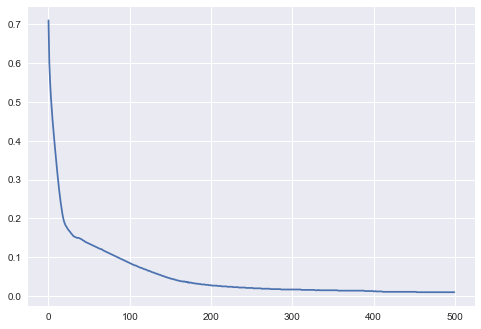

Wall time: 48min 11s


In [25]:
%%time
# Create torch train/validation data sets
net = Net(X_median_smote.shape[1]) # Insert feature here!

# Loss function
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

traininglosses = []
testlosses = []

for train_index, valid_index in tqdm(skf.split(X_median_smote, y_median_smote)):
    X_strat_train, X_validation = torch.from_numpy(X_median_smote[train_index]).float(), torch.from_numpy(X_median_smote[valid_index]).float()
    y_strat_train, y_validation = torch.from_numpy(y_median_smote[train_index]).float(), torch.from_numpy(y_median_smote[valid_index]).float()

    # Train
    for epoch in range(100):
        
        y_strat_pred = net(X_strat_train)
        
        y_strat_pred = torch.squeeze(y_strat_pred)
        train_loss = criterion(y_strat_pred, y_strat_train)
        
        traininglosses.append(round_tensor(train_loss))

        if epoch % 100 == 0:
            train_acc = calculate_accuracy(y_strat_train, y_strat_pred)

            y_test_pred = net(X_validation)
            y_test_pred = torch.squeeze(y_test_pred)

            test_loss = criterion(y_test_pred, y_validation)
            testlosses.append(round_tensor(test_loss))
            test_acc = calculate_accuracy(y_test_pred, y_validation)
            print(
        f'''epoch {epoch}
        Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
        Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
        ''')
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

plt.plot(traininglosses)
plt.show()

In [ ]:
break

losses = [np.array(x.history['loss']) for x in histories]

np.mean(accuracies)

plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], '--', label="Validation Loss")
plt.legend()
plt.title("Binary Crossentropy loss")

0.7705095177815201

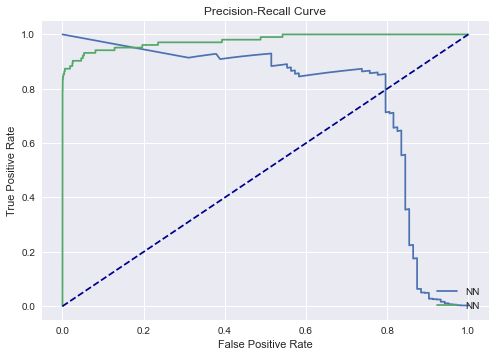

In [55]:
create_pr_curve(nn.predict(X_test), y_test, label="NN", title="Precision-Recall Curve")
create_roc_curve(nn.predict(X_test), y_test, label="NN", title="Precision-Recall Curve")
AUC_PR(nn.predict(X_test))

No handles with labels found to put in legend.


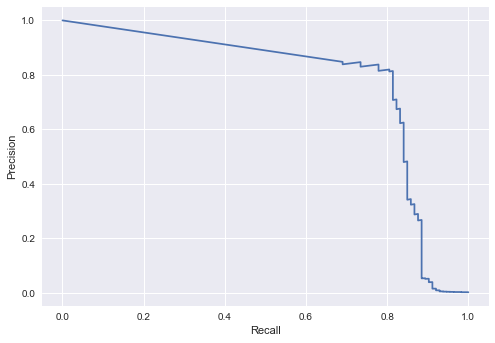

In [48]:
hh = torch.from_numpy(X_median_test).float()
preds_proba = net(hh).detach()
create_pr_curve(preds_proba, y_median_test)

In [172]:
nn.predict(X_test)

array([[1.4218688e-04],
       [1.2143117e-06],
       [2.0139258e-05],
       ...,
       [2.2586777e-05],
       [3.7044287e-04],
       [2.6144360e-05]], dtype=float32)

In [156]:
history.history['prc']

[0.5168852210044861,
 0.5410658717155457,
 0.5346726179122925,
 0.4704974889755249,
 0.4345034062862396,
 0.4164983332157135]

In [157]:
nn.evaluate(X_test)

2226/2226 [==============================] - 1s 640us/step - loss: 0.0000e+00 - prc: 0.0000e+00


[0.0, 0.0]

plt.plot(history.history['val_loss'], label="val loss")

In [122]:
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': [1000, 200],
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [119]:
evaluate_model(lrg, verbose=True)

 performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9989887924496503
False negatives: 21
False positives: 51
True positives: 60
F1 score: 0.625
AUPRC: 0.660891641643524
AUC ROC: 0.9598326013062055
Average Precision Score: 0.6622137705085297
Mean Score for Metrics: 0.7269845033645649



[0.625,
 0.660891641643524,
 0.9598326013062055,
 0.6622137705085297,
 0.7269845033645649]

In [50]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)

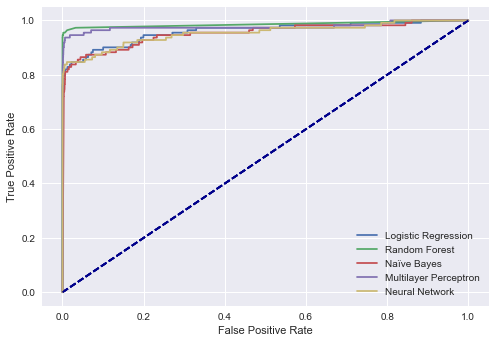

In [175]:
create_roc_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Logistic Regression")
#create_roc_curve(svc.predict_proba(X_test)[:,1], y_test, label="Support Vector Classifier")
create_roc_curve(rfc.predict_proba(X_test)[:,1], y_test, label="Random Forest")
create_roc_curve(nb.predict_proba(X_test)[:,1], y_test, label="Naïve Bayes")
create_roc_curve(mlp.predict_proba(X_test)[:,1], y_test, label="Multilayer Perceptron")
create_roc_curve(nn.predict(X_test), y_test, label="Neural Network")

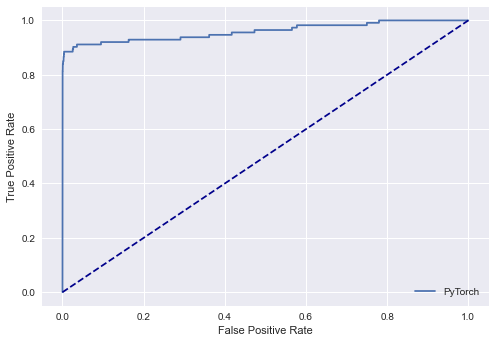

In [51]:
create_roc_curve(preds_proba, y_median_test, label="PyTorch")

## Precicion Recall Curve

In [46]:
def plot_pr_cur(p, r, label="", title="plot title"):
    plt.plot(r, p, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    
def create_pr_curve(preds, targets, label="", title=""):
    all_p, all_r = [], []
    p, r, thresholds = precision_recall_curve(targets, preds)
    all_p.append(p)
    all_r.append(r)
    all_p = np.array(p)
    all_r = np.array(r)
    
    plot_pr_cur(all_p, all_r, label=label, title=title)

In [ ]:
create_pr_curve(lrg_preds['all'][:,1], y_test, label="Logistic Regression")
create_pr_curve(mlp_preds['all'][:,1], y_test, label="Multilayer Perceptron")
create_pr_curve(rfc_preds['all'][:,1], y_test, label="Random Forest")
create_pr_curve(nbc_preds['all'][:,1], y_test, label="Naive Bayes")
create_pr_curve(dum_preds['all'][:,1], y_test, label="Baseline", title="Precision-Recall Curve")


create_pr_curve(nn.predict(X_test), y_test, label="NN")

In [115]:
baseline_preds['all']

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       ...,
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

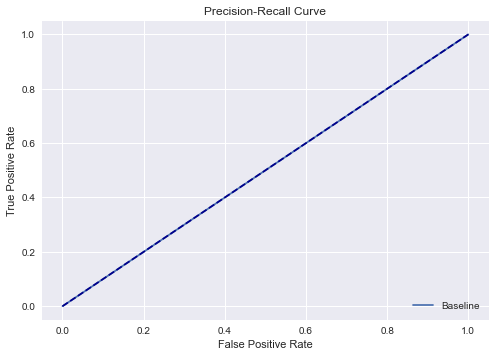

In [118]:
create_roc_curve(baseline_preds['all'][:,1], y_test, label="Baseline", title="Precision-Recall Curve")